# **Food Vision 101 project Using TensorFlow**

## Creating helper functions
in previous notebooks , we've created a bunch of helper functions , now we could rewrite them all , however this tedious

**🔑 Note:** If you're running this notebook in Google Colab, when it times out Colab will delete the helper_functions.py file. So to use the functions imported above, you'll have to rerun the cell.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-27 21:16:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-27 21:16:47 (12.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data ,walk_through_dir

## Let's get some data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the tf.keras.applications module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, image_dataset_from_directory() which is part of the tf.keras.utils module.

Finally, we'll also be practicing using the Keras Functional API for building deep learning models. **The Functional API**is a more flexible way to create models than the**tf.keras.Sequential API.**

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

**Link:** https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 calsses of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2024-05-27 21:16:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 74.125.204.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.3MB/s    in 6.6s    

2024-05-27 21:16:54 (24.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                             batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Model 0 : Building a transfer learning model using the keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as EfficientNetV2B0 from tf.keras.applications.efficientnet_v2, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.

**🤔Note:** As of writing, the EfficientNet (and EfficientNetV2) models in the tf.keras.applications module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted an issue to the TensorFlow GitHub about this and they confirmed this.

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
7. Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using tf.keras.Model().
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).
Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# 2. Freeze the base model (so the underlying pre-trained pattrens are not updated during training)
base_model.trainable = False
# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224 , 224 ,3), name="input_layer")
# 4. If using a model likeResNet50v2 you will need to normalize inputs (You do not have to for EfficetNetB0)
# x = tf.keras.layer.experimental.preprocessing.Rescaling(1./255)(input)
# 5. pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")
# 6. average pool the outputs(output a feature vector here) of the base_model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")
# 7. Creating the activation function layer
outputs = tf.keras.layers.Dense(10 ,activation="softmax" ,name="outputlayer")(x)
# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs , outputs)
# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [ ]:
# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_pecent_feature_experment")])

Saving TensorBoard log files to: transfer_learning/10_pecent_feature_experment/20240527-211702
Epoch 1/5
24/24 [==============================] - 151s 6s/step - loss: 1.8996 - accuracy: 0.4053 - val_loss: 1.3303 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 137s 6s/step - loss: 1.1000 - accuracy: 0.7667 - val_loss: 0.8631 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 141s 6s/step - loss: 0.7953 - accuracy: 0.8120 - val_loss: 0.6777 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 137s 6s/step - loss: 0.6455 - accuracy: 0.8627 - val_loss: 0.5895 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 137s 6s/step - loss: 0.5414 - accuracy: 0.8840 - val_loss: 0.5451 - val_accuracy: 0.8635


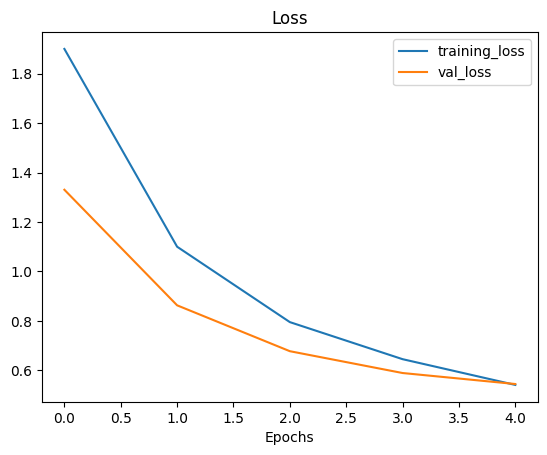

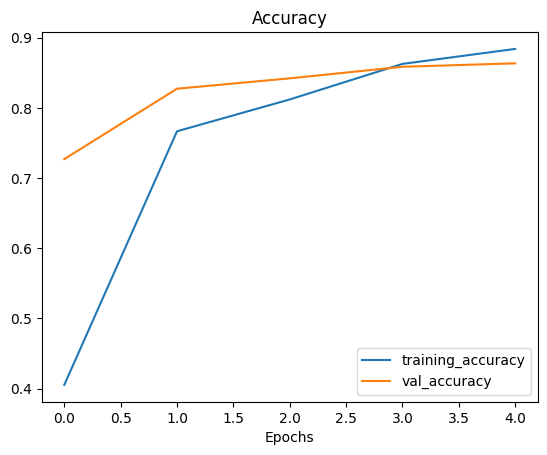

In [ ]:
# 11. Plot the loss
plot_loss_curves(history_0)

In [ ]:
# evaluate on the full test dataset
bot = model_0.evaluate(test_data)

79/79 [==============================] - 190s 2s/step - loss: 0.5571 - accuracy: 0.8596


In [ ]:
# Check the layers in our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

## Getting a feature vector from a trained model

**🤔 Question:** What happens with the tf.keras.layers.GlobalAveragePooling2D() layer? I haven't seen it before.

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [ ]:
# Define the input shape
input_shape = (1 , 4 , 4 , 3)
# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# Pass the random tensor through  a GAP2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n ")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
2D global average pooled random tensor:
[[-0.09368646 -0.45840445 -0.28855976]]
 


**🔑 Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

## Running a series of transfer learning experiment


We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

1. Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
4. Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.
While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetV2B0 model within the tf.keras.applications.efficientnet_v2 module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2024-05-27 21:33:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  19.1MB/s    in 7.6s    

2024-05-27 21:33:26 (16.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent ="10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

**🔑 Note:** As with the 10% of data subset, the 1% of images were chosen at random from the original full training dataset. The test images are the same as the ones which have previously been used. If you want to see how this data was preprocessed, check out the Food Vision Image Preprocessing notebook.

In [ ]:
# Create data inputs
IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

o use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:

* tf.keras.layers.RandomFlip - flips image on horizontal or vertical axis.
* tf.keras.layersRandomRotation - randomly rotates image by a specified amount.
* tf.keras.layers.RandomZoom - randomly zooms into an image by specified amount.
* tf.keras.layers.RandomHeight - randomly shifts image height by a specified amount.
* tf.keras.layers.RandomWidth - randomly shifts image width by a specified amount.
* tf.keras.layers.Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using tf.keras.applications.efficientnet_v2.EfficientNetV2B0, it's not required (the model pretrained model implements rescaling itself).
There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# Create data augmentation stage with horizontal , flipping ....
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
] , name="data_augmentation")


And that's it! Our data augmentation Sequential model is ready to go. As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

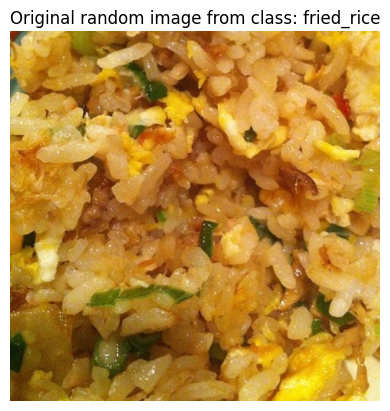

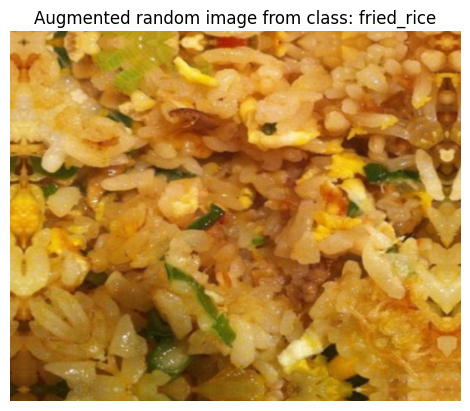

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the underlying pre-trained pattrens are not updated during training)
base_model.trainable = False
# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224 , 224 , 3), name="input_layer")
# 4. If using a model likeResNet50v2 you will need to normalize inputs (You do not have to for EfficetNetB0)
# x = tf.keras.layer.experimental.preprocessing.Rescaling(1./255)(input)
# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)
# 5. pass the input to the base model
x = base_model(x , training=False)
# 6. average pool the outputs(output a feature vector here) of the base_model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# 7. Creating the activation function layer
outputs = tf.keras.layers.Dense(10 , activation="softmax" , name="output_layer")(x)
# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs , outputs)
# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
# 10. Fit the model
history_1 = model_1.fit(train_data_1_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_1_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback("transfer_learning" , "1_percent_feature_experment")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_experment/20240527-213337
Epoch 1/5
3/3 [==============================] - 152s 70s/step - loss: 2.4983 - accuracy: 0.0714 - val_loss: 2.2327 - val_accuracy: 0.1516
Epoch 2/5
3/3 [==============================] - 140s 69s/step - loss: 2.2793 - accuracy: 0.1429 - val_loss: 2.1202 - val_accuracy: 0.2264
Epoch 3/5
3/3 [==============================] - 139s 68s/step - loss: 2.0971 - accuracy: 0.2857 - val_loss: 2.0226 - val_accuracy: 0.3060
Epoch 4/5
3/3 [==============================] - 149s 72s/step - loss: 1.9782 - accuracy: 0.4143 - val_loss: 1.9322 - val_accuracy: 0.3764
Epoch 5/5
3/3 [==============================] - 140s 68s/step - loss: 1.8500 - accuracy: 0.4857 - val_loss: 1.8510 - val_accuracy: 0.4300


In [ ]:
# Evaluate the test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 135s 2s/step - loss: 1.8510 - accuracy: 0.4300


[1.850972294807434, 0.4300000071525574]

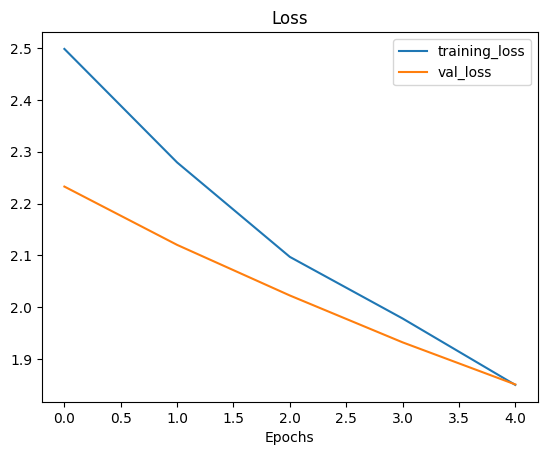

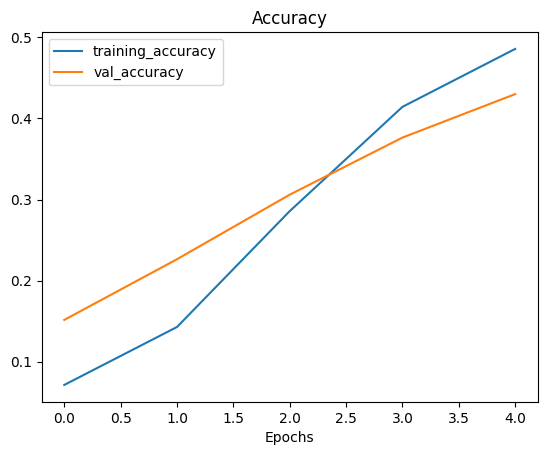

In [ ]:
# Plot the loss
plot_loss_curves(history_1)

# Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Steps :
1. Load the data (Upload the data or paste the link).

2. Split the data into train and test dataset (also validation if needed)

3. Build the model and fit it in the training data.

4. evaluate the model using test data

In [ ]:
# Get 10 percent of data.... (uncomment if you do not have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set data input
import tensorflow as tf
IMG_SIZE = (224 , 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            batch_size=32,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=32,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # Preprocessing.Rescaling(1./255) # if you are using a model such as ResNet50v2 you will need to rescale your data
] , name = "data_augmentation")

# Set up the input shape to our model
#input_shape = (224 , 224 , 3)
# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape=(224 , 224 , 3) , name="Input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x , training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_average_pooling")(x)
outputs = tf.keras.layers.Dense(10 , activation="softmax" , name="output_layer")(x)
model_2 = tf.keras.Model(inputs , outputs)

In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Creating a ModelCheckPoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the ModelCheckpoint callback.

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a ModelCheckpoint callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # Save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9718 - accuracy: 0.3827
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 260s 11s/step - loss: 1.9718 - accuracy: 0.3827 - val_loss: 1.4150 - val_accuracy: 0.6868
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2687 - accuracy: 0.6867
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 247s 11s/step - loss: 1.2687 - accuracy: 0.6867 - val_loss: 0.9795 - val_accuracy: 0.7792
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9831 - accuracy: 0.7720
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 269s 12s/step - loss: 0.9831 - accuracy: 0.7720 - val_loss: 0.7915 - val_accuracy: 0.8120
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.7987
E

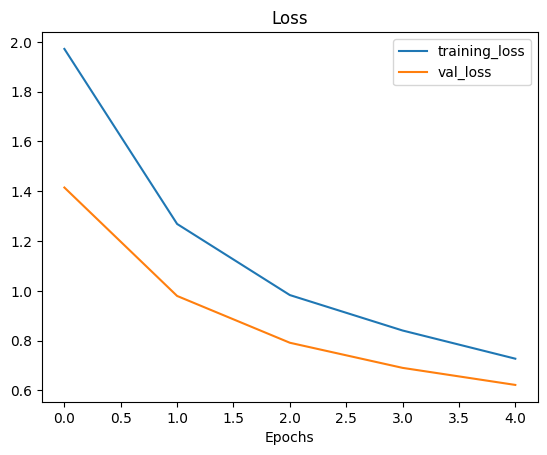

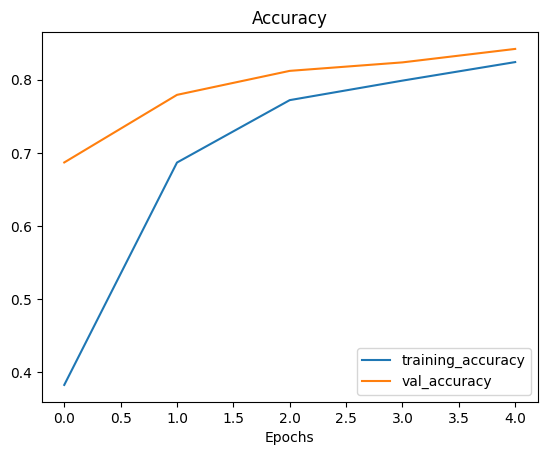

In [ ]:
# Plot the loss curve
plot_loss_curves(history_2)

### Loading in checkpointed weight

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 182s 2s/step - loss: 0.6221 - accuracy: 0.8420


# Model 3: Fine-tuning an existing model on 10% of the data

**🔑 Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out Keras' guide on Transfer learning & fine-tuning.

In [ ]:
# Layers in loaded model
model_2.layers


In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer , layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78acc9d8f8e0> True
<keras.src.engine.sequential.Sequential object at 0x78acb9619b40> True
<keras.src.engine.functional.Functional object at 0x78acb9575fc0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78ad68309840> True
<keras.src.layers.core.dense.Dense object at 0x78acb9577ac0> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i , layer in enumerate(model_2.layers[2].layers):
  print(i , layer.name , layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# to begin fine-tuning , let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # When fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])


Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

**🤔 Question:**Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

**🔑 Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

How many trainable variables do we have now?

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables do we have now?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5
# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune = model_2.fit(train_data_10_percent,
                                epochs = fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                initial_epoch=history_2.epoch[-1]) # Start training from previous last epoch

Epoch 5/10
24/24 [==============================] - 255s 10s/step - loss: 0.6982 - accuracy: 0.7773 - val_loss: 0.4585 - val_accuracy: 0.8556
Epoch 6/10
24/24 [==============================] - 251s 11s/step - loss: 0.3203 - accuracy: 0.9013 - val_loss: 0.3953 - val_accuracy: 0.8728
Epoch 7/10
24/24 [==============================] - 240s 10s/step - loss: 0.1991 - accuracy: 0.9413 - val_loss: 0.3959 - val_accuracy: 0.8764
Epoch 8/10
24/24 [==============================] - 265s 11s/step - loss: 0.1367 - accuracy: 0.9573 - val_loss: 0.4446 - val_accuracy: 0.8612
Epoch 9/10
24/24 [==============================] - 232s 10s/step - loss: 0.1485 - accuracy: 0.9493 - val_loss: 0.4189 - val_accuracy: 0.8672
Epoch 10/10
24/24 [==============================] - 263s 11s/step - loss: 0.0792 - accuracy: 0.9840 - val_loss: 0.4309 - val_accuracy: 0.8752


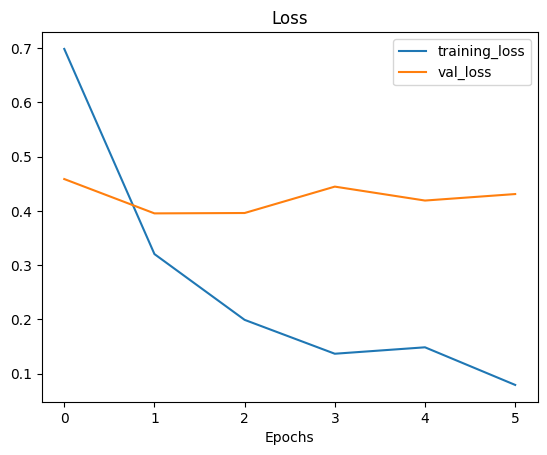

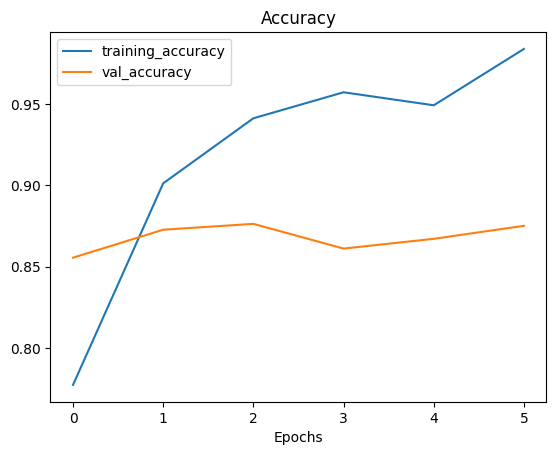

In [ ]:
# Plot the loss curve
plot_loss_curves(history_fine_tune)

In [ ]:
# Evaluate the fine-tuned model
model_2.evaluate(test_data)

79/79 [==============================] - 173s 2s/step - loss: 0.4309 - accuracy: 0.8752


[0.4308607876300812, 0.8751999735832214]

Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.382666677236557, 0.6866666674613953, 0.7720000147819519, 0.7986666560173035, 0.8240000009536743, 0.7773333191871643, 0.9013333320617676, 0.9413333535194397, 0.9573333263397217, 0.9493333101272583, 0.984000027179718]


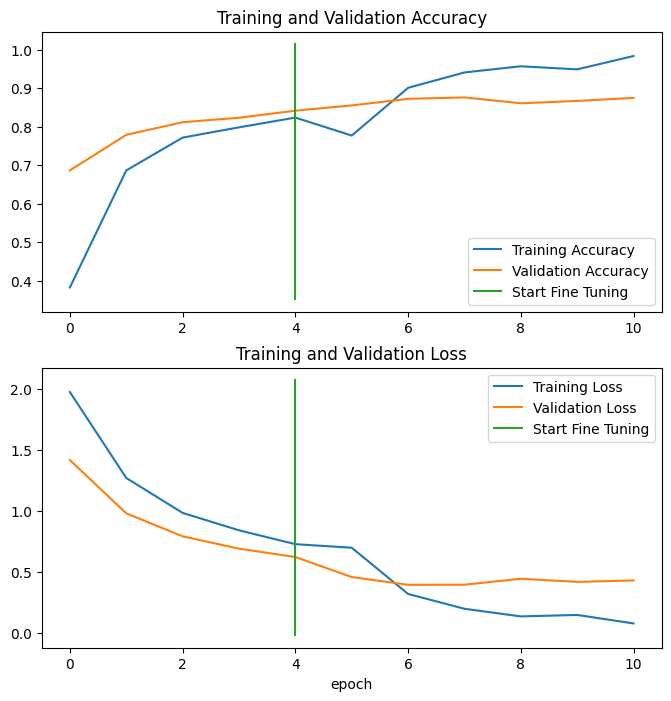

In [ ]:
compare_historys(original_history=history_2,
                 new_history=history_fine_tune,
                 initial_epochs=5)

#Model 4: Fine-tuning an existing model all of the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-05-27 22:46:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 74.125.204.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.3’

10_food_classes_all 100%[===================>] 495.13M  30.2MB/s    in 17s     

2024-05-27 22:46:28 (29.0 MB/s) - ‘10_food_classes_all_data.zip.3’ saved [519183241/519183241]



In [ ]:
# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224 , 224 )
train_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     image_size=IMG_SIZE,
                                                                     label_mode="categorical",
                                                                     batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=32,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The **test dataset** is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current mod

In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 196s 2s/step - loss: 0.4309 - accuracy: 0.8752


[0.4308607280254364, 0.8751999735832214]

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (model_2 feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of model_2.



In [ ]:
# Create a new instance of model_2 for Experiment 4
#model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 188s 2s/step - loss: 0.4309 - accuracy: 0.8752


[0.4308607280254364, 0.8751999735832214]

In [ ]:
# Check which layers are tunable in the whole model
for layer_number , layer in enumerate(model_2.layers):
  print(layer_number , layer.name , layer.trainable)

0 Input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_average_pooling True
4 output_layer True


In [ ]:
# Let's drill into our base_model and see what layersare trainable
for layer_number , layer , in enumerate(model_2.layers[2].layers):
  print(layer_number , layer.name , layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5
history_fine_tune_alldata = model_2.fit(train_all_data,
                                        epochs=fine_tune_epochs,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)),
                                        initial_epoch=history_2.epoch[-1],
                                        callbacks=[checkpoint_callback])

Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.8273
Epoch 5: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 741s 3s/step - loss: 0.5562 - accuracy: 0.8273 - val_loss: 0.3765 - val_accuracy: 0.8799
Epoch 6/10
229/235 [============================>.] - ETA: 16s - loss: 0.3885 - accuracy: 0.8735
Epoch 6: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 716s 3s/step - loss: 0.3894 - accuracy: 0.8731 - val_loss: 0.2851 - val_accuracy: 0.9161
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8989
Epoch 7: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
235/235 [==============================] - 695s 3s/step - loss: 0.3024 - accuracy: 0.8989 - val_loss: 0.3058 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - ETA: 0s - loss: 0.2541 - ac

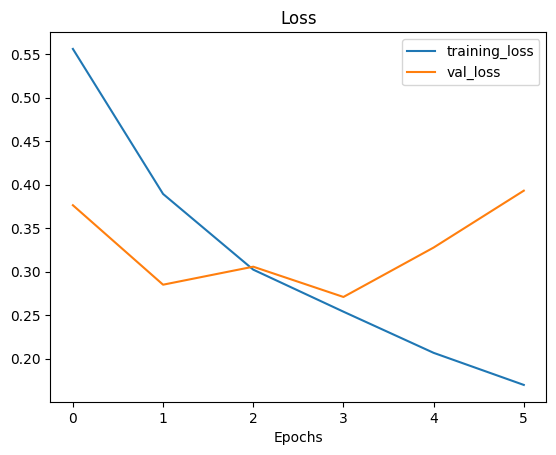

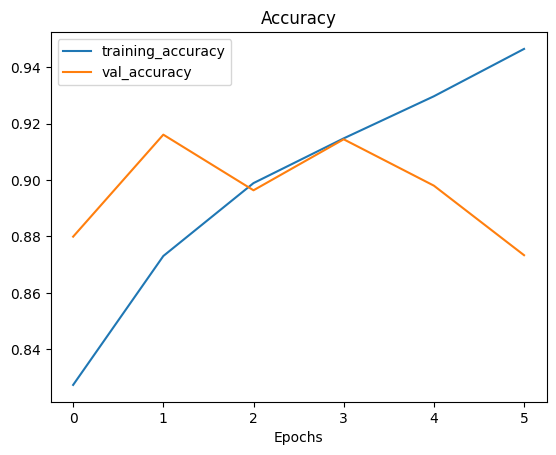

In [ ]:
# Plot the curves
plot_loss_curves(history_fine_tune_alldata)

5
11
[0.382666677236557, 0.6866666674613953, 0.7720000147819519, 0.7986666560173035, 0.8240000009536743, 0.8273333311080933, 0.8730666637420654, 0.8989333510398865, 0.9147999882698059, 0.9297333359718323, 0.9465333223342896]


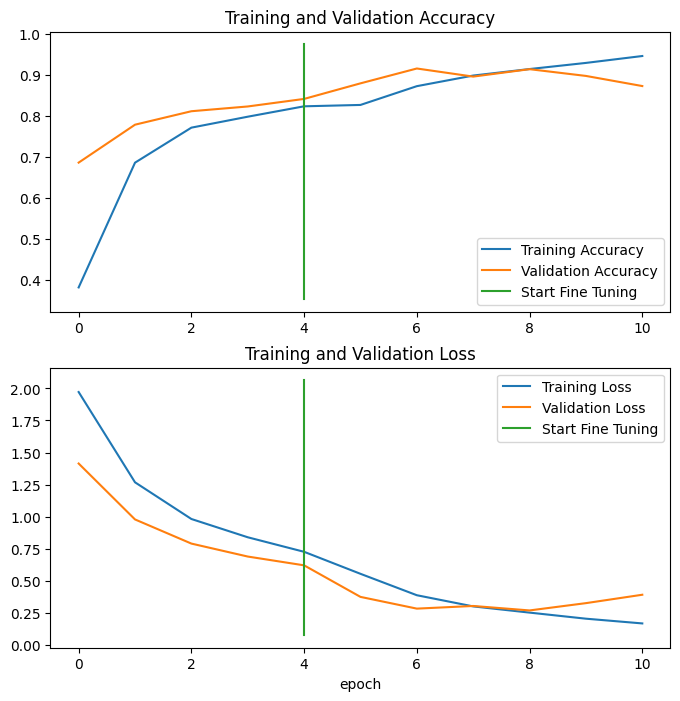

In [ ]:
# Plot the history before and after fine-tuning
compare_historys(original_history=history_2,
                 new_history=history_fine_tune_alldata,
                 initial_epochs=5)

# Comparing our modeling experiment

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function create_tensorflow_callback(), we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the tensorboard dev upload command and passing it the directory where our experiments have been logged.

**🔑 Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
#   --one_shot # exits the uploader when upload has finished

